## 準備

### サンプルデータのダウンロード
著者サイトで公開されているデータを使います。

http://hosho.ees.hokudai.ac.jp/~kubo/ce/IwanamiBook.html

In [1]:
import requests
import zipfile
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
%precision 3

'%.3f'

In [3]:
# 全カラムを表示させる
pd.set_option('display.max_columns', None)

### 種子数データ

In [4]:
# 著者サイトからdata3a.csvをダウンロード
response = requests.get('http://hosho.ees.hokudai.ac.jp/~kubo/stat/iwanamibook/fig/poisson/data3a.csv')
with open ('data3a.csv', 'wb') as f:
    f.write(response.content)
    f.close()

In [5]:
# サンプルデータをロード
data = pd.read_csv('data3a.csv')

In [6]:
# 先頭5行の表示
data.head()

,y,x,f
0,6,8.31,C
1,6,9.44,C
2,6,9.50,C
3,12,9.07,C
4,10,10.16,C


## 4.2 統計モデルのあてはまりの悪さ：逸脱度

In [7]:
# xモデルを作る
x_model_results = sm.GLM(data['y'], sm.add_constant(data['x']), family=sm.families.Poisson()).fit()

x_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -235.39
Date:                Wed, 31 Jan 2018   Deviance:                       84.993
Time:                        14:33:54   Pearson chi2:                     83.8
No. Iterations:                     7                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.2917      0.364      3.552      0.000         0.579     2.005
x              0.0757      0.036      2.125      0.034         0.006     0.145
==============================================================================
"""

In [8]:
# xモデルの逸脱度
x_model_d = x_model_results.llf*(-2)
print('X model deviance:', x_model_d)

X model deviance: 470.77250154


In [9]:
# フルモデルの最大対数尤度
full_model_ll = sum([poisson.logpmf(y_i, y_i) for y_i in data['y']])
print('Full model log-likelihood:', full_model_ll)

# フルモデルの逸脱度(最小逸脱度)
full_model_d = (-2) * full_model_ll
print('Min deviance:', full_model_d)

Full model log-likelihood: -192.889752524
Min deviance: 385.779505049


In [10]:
# xモデルの残差逸脱度(上の"Deviance"の値と一致します。results.devianceでも表示できます)
x_model_r = (-2) * (x_model_results.llf - full_model_ll)
print('Residual deviance:', x_model_r)

Residual deviance: 84.9929964907


In [11]:
# nullモデル
null_model_results = sm.GLM(data['y'], np.ones(len(data)), family=sm.families.Poisson()).fit()

null_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       99
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -237.64
Date:                Wed, 31 Jan 2018   Deviance:                       89.507
Time:                        14:33:57   Pearson chi2:                     87.1
No. Iterations:                     7                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          2.0580      0.036     57.586      0.000         1.988     2.128
==============================================================================
"""

In [12]:
# nullモデルの逸脱度
null_model_d = (-2) * null_model_results.llf

print('Null deviance:', null_model_d)

Null deviance: 475.286442619


## 4.4 AICを説明するためのまた別の問題

In [13]:
np.random.seed(10) # 一定の値になるようにシードを0で固定

# xに4〜12のポアソン乱数をセット
data_random = pd.DataFrame(np.random.poisson(8, 50), columns=['y'])

data_random.describe()

,y
count,50.00000
mean,7.44000
std,2.49211
min,3.00000
25%,6.00000
50%,7.00000
75%,9.00000
max,13.00000


## 4.5 なぜAICでモデル選択してよいのか？

In [14]:
# λi=exp(β1)における最尤推定
model = smf.poisson('y ~ 1', data=data_random)
results = model.fit()

results.summary()

Optimization terminated successfully.
         Current function value: 2.329301
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                   50
Model:                        Poisson   Df Residuals:                       49
Method:                           MLE   Df Model:                            0
Date:                Wed, 31 Jan 2018   Pseudo R-squ.:                   0.000
Time:                        14:34:04   Log-Likelihood:                -116.47
converged:                       True   LL-Null:                       -116.47
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      2.0069      0.052     38.707      0.000         1.905     2.108
==============================================================================
"""

In [15]:
# 真のモデルから200セットのデータを生成
data_random_200 = [pd.DataFrame(np.random.poisson(8, len(data_random)), columns=['y']) for i in range(200)]

# 200セットのデータに対して、β1=2.0268で200個の対数尤度を計算
lls = []
for d in data_random_200:
    lls.append(sum(poisson.logpmf(d, math.exp(results.params['Intercept']))))
    
# 平均対数尤度を計算
elogl = np.sum(lls) / len(lls)
print('E(log L):', elogl)

E(log L): -123.312953609


In [16]:
# 1セットの最大対数尤度と200セットの平均対数尤度を200回ずつ計測する
logls = []
elogls = []

for i in range(200):
    data_random = pd.DataFrame(np.random.poisson(8, 50), columns=['y'])
    
    results = smf.poisson('y ~ 1', data=data_random).fit(disp=0)
    logls.append(results.llf)
    
    data_random_200 = [pd.DataFrame(np.random.poisson(8, len(data_random)), columns=['y']) for i in range(200)]
    
    lls = []
    for d in data_random_200:
        lls.append(sum(poisson.logpmf(d, math.exp(results.params['Intercept']))))
    elogls.append(np.sum(lls) / len(lls))

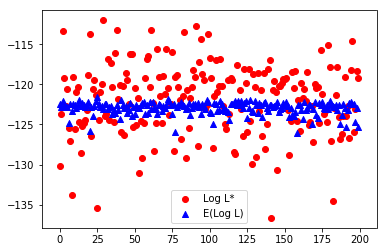

In [17]:
# 最大対数尤度(赤○)と平均対数尤度(青▲)を散布図でプロット
x = np.arange(200)
plt.scatter(x, logls, color='red', marker='o', label='Log L*')
plt.scatter(x, elogls, color='blue', marker='^', label='E(Log L)')
plt.legend(loc='best')
plt.show()

In [18]:
# 最大対数尤度と平均対数尤度の標本平均の差(=バイアス)を計算
b = np.average(logls) - np.average(elogls)
print('Bias:', b)

Bias: 1.05220186818


In [19]:
# 200セットのデータに対して一定モデルとxモデルで、最大対数尤度と平均対数尤度を計算
logls = []
elogls = []
xlogls = []
xelogls = []

for i in range(200):
    # 説明変数と目的変数が無関係の観測データ1セットを作る
    data_random = pd.concat(
        [pd.DataFrame(np.random.poisson(8, 50), columns=['y']), pd.DataFrame(np.random.rand(50)*9+1, columns=['x'])], 
        axis=1)
    
    # 一定モデルによる最尤推定
    results = smf.poisson('y ~ 1', data=data_random).fit(disp=0)
    logls.append(results.llf)
    
    # xモデルによる最尤推定
    xresults = smf.poisson('y ~ x', data=data_random).fit(disp=0)
    xlogls.append(xresults.llf)
    
    # 真のモデルから新たなデータ200セットを作る
    data_random_200 = [pd.concat(
        [pd.DataFrame(np.random.poisson(8, 50), columns=['y']), pd.DataFrame(np.random.rand(50)*9+1, columns=['x'])], 
        axis=1) for i in range(200)]    

    # 200セットの対数尤度を計算
    lls = []
    xlls= []
    for d in data_random_200:
        lls.append(sum(poisson.logpmf(d['y'], math.exp(results.params['Intercept']))))
        xlls.append(sum(poisson.logpmf(d['y'], np.exp(xresults.params['Intercept'] + d['x'] * xresults.params['x']))))
        
    # 平均対数尤度を計算
    elogls.append(np.average(lls))
    xelogls.append(np.average(xlls))

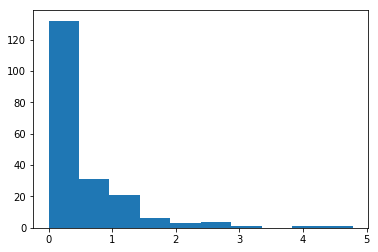

0.523914460243


In [20]:
# 最大対数尤度の差
logls_diff = np.subtract(xlogls, logls)

plt.hist(logls_diff, bins=10)
plt.show()

# 最大対数尤度の差の平均
print(np.average(logls_diff))

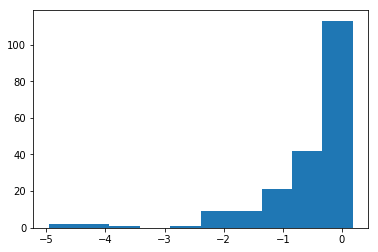

-0.566903500325


In [21]:
# 平均対数尤度の差
elogls_diff = np.subtract(xelogls, elogls)

plt.hist(elogls_diff, bins=10)
plt.show()

# 平均対数尤度の差の平均
print(np.average(elogls_diff))

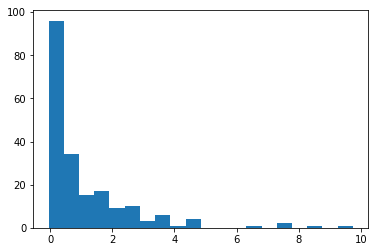

1.09081796057


In [22]:
# バイアスの差
b_diff = logls_diff - elogls_diff

plt.hist(b_diff, bins=20)
plt.show()

# バイアスの差の平均
print(np.average(b_diff))

In [23]:
# 一定モデルのAIC
aic = -2 * logls[0] + 2
print(aic)

258.089012092


In [24]:
# xモデルのAIC
aic = -2 * xlogls[0] + 4
print(aic)

259.046953496


## 欠席数データに対してAICでモデルを選択する

### 準備

In [25]:
# student.zipをダウンロード
response = requests.get('https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip')
with open ('student.zip', 'wb') as f:
    f.write(response.content)
    f.close()

In [26]:
# カレントディレクトリに解凍
zfile = zipfile.ZipFile('student.zip')
zfile.extractall('.')

In [27]:
# 数学の成績(student-mat.csv)をロード
student_math_data = pd.read_csv('student-mat.csv', delimiter=';')
student_math_data = student_math_data[student_math_data['absences'] < 30] # 欠席回数30以上は外れ値として除外

student_math_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


In [28]:
# 欠席回数(カウントデータ)を目的変数として使う
# 欠席数の分布が偶数に偏っている
# そこで2で割って切り捨てることで、欠席数0〜1の人は0回、2〜3の人は1回、・・・となるようにする
absences = pd.Series(student_math_data['absences'] / 2, dtype=int) 

# 年齢(age)を説明変数として使う
age = student_math_data['age']

student_data = pd.concat([absences, age], axis=1)

In [29]:
student_data.head()

,absences,age
0,3,18
1,2,17
2,5,15
3,1,15
4,2,16


### ageモデルと一定モデルを構築

In [30]:
# ageモデルを作る
age_model = smf.poisson('absences ~ age', data=student_data)
age_model_results = age_model.fit(disp=0)

age_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:               absences   No. Observations:                  389
Model:                        Poisson   Df Residuals:                      387
Method:                           MLE   Df Model:                            1
Date:                Wed, 31 Jan 2018   Pseudo R-squ.:                 0.01418
Time:                        14:36:11   Log-Likelihood:                -982.69
converged:                       True   LL-Null:                       -996.83
                                        LLR p-value:                 1.051e-07
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -1.3029      0.414     -3.149      0.002        -2.114    -0.492
age            0.1315      0.024      5.386      0.000         0.084     0.179
==============================================================================
"""

In [31]:
# 一定モデルを作る
const_model = smf.poisson('absences ~ 1', data=student_data)
const_model_results = const_model.fit(disp=0)

const_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:               absences   No. Observations:                  389
Model:                        Poisson   Df Residuals:                      388
Method:                           MLE   Df Model:                            0
Date:                Wed, 31 Jan 2018   Pseudo R-squ.:                   0.000
Time:                        14:36:11   Log-Likelihood:                -996.83
converged:                       True   LL-Null:                       -996.83
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.9044      0.032     28.036      0.000         0.841     0.968
==============================================================================
"""

### フルモデルから残差逸脱度を求める

In [32]:
# フルモデルの最大対数尤度
full_model_ll = sum([poisson.logpmf(y_i, y_i) for y_i in student_data['absences']])
print('Full log-likelihood:', full_model_ll)

# フルモデルの逸脱度(最小逸脱度)
full_model_deviance = (-2) * full_model_ll
print('Min deviance:', full_model_deviance)

Full log-likelihood: -392.854706449
Min deviance: 785.709412899


In [36]:
# 一定モデルの残差逸脱度
const_model_d = -2 * (const_model_results.llf - full_model_ll)
print('Const model residuals:', const_model_d)

# ageモデルの残差逸脱度
age_model_d = -2 * (age_model_results.llf - full_model_ll)
print('Age model residuals:', age_model_d)

Const model residuals: 1207.95059528
Age model residuals: 1179.67358728


### AICを比較する
ageモデルのAIC < 一定モデルのAIC のため、ageモデルを選択すべきという結論になる。

In [37]:
# AICの比較
const_model_aic = const_model_d + 2
print('Const model AIC:', const_model_aic)

age_model_aic = age_model_d + 4
print('Age model AIC:', age_model_aic)

Const model AIC: 1209.95059528
Age model AIC: 1183.67358728
